In [1]:
import configparser
import numpy as np
from src.clustering.algorithm_wrappers.KMeansWrapper import KMeansWrapper
import pandas as pd

In [2]:
config = configparser.ConfigParser()
config.read('../../config.ini')
embedding_path = '../../' + config['DATA']['UserEmbeddingPath']
test_path = '../../' + config['DATA']['TestUserEmbeddingPath']


In [3]:
from sklearn.preprocessing import StandardScaler
import umap

user_embedding = np.load(embedding_path)  # todo get_historic_user_embeddings
test_embedding = np.load(test_path)

# standardize data
scaler = StandardScaler().fit(user_embedding)
user_embedding = scaler.transform(user_embedding)
test_embedding = scaler.transform(test_embedding)

# transform data
N_NEIGHBORS= int(config['UMAP']['n_neighbors'])
MIN_DIST= float(config['UMAP']['min_dist'])
N_COMPONENTS= int(config['UMAP']['n_components'])
METRIC=config['UMAP']['metric']
fit = umap.UMAP(
    n_neighbors= N_NEIGHBORS,
    min_dist= MIN_DIST,
    n_components= N_COMPONENTS,
    metric=METRIC
)

reducer = fit.fit(user_embedding)
user_red = reducer.transform(user_embedding)
user_test_red = reducer.transform(test_embedding)


/home/vera/uni/Master/SoSe23/EAI/04-continous-user-feedback/venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vera/uni/Master/SoSe23/EAI/04-continous-user-feedback/venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vera

In [4]:
model = KMeansWrapper()
model.train(user_red)
model.extract_representations(user_red)  # return tuple (clusterid, location)

# Load frequency data and categories

In [39]:
# for each cluster get user frequencies
import json
user_mapping = json.load(open('../../data/user_mapping.json'))

#load frequencies
df = pd.read_csv('../../data/wordclouds/user_category_frequency.csv')
user_categories = df.loc[df['user'].isin(user_mapping.keys())]
del df
user_categories

,Unnamed: 0,user,video,northamerica,sports,news,autos,kids,movies,lifestyle,middleeast,foodanddrink,music,travel,health,finance,entertainment,weather,tv
1,1,U91836,2,0,3,60,0,0,1,6,0,4,1,7,1,8,0,2,0
5,5,U19739,1,0,10,26,1,0,0,2,0,2,1,1,2,0,1,0,1
10,10,U89744,1,0,50,16,0,0,3,14,0,0,4,0,1,6,8,1,2
12,12,U92486,1,0,34,31,0,0,7,8,0,4,2,0,1,6,2,0,4
13,13,U29155,0,0,20,12,2,0,6,2,0,3,9,1,5,3,8,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34768,34768,U59698,2,0,3,25,2,0,4,21,0,5,4,5,3,2,4,2,9
36382,36382,U64289,0,0,1,18,0,0,0,0,0,0,0,0,0,2,3,0,3
36457,36457,U61054,1,0,20,21,1,0,2,1,0,0,1,0,2,3,2,4,4
38091,38091,U16852,0,0,0,2,0,0,1,6,0,0,1,1,1,1,0,0,2


Get category frequency

In [45]:
df = pd.read_csv('../../data/MINDsmall_train/news.tsv',  sep="\t", header=None)
counter = df[1].value_counts()
category_freq = counter / counter.sum() * 100
category_freq

1
news             30.759331
sports           28.294528
finance           6.058656
foodanddrink      4.974455
lifestyle         4.834055
travel            4.582505
video             4.032604
weather           3.993604
health            3.675754
autos             3.196053
tv                1.733552
music             1.499551
movies            1.181701
entertainment     1.144651
kids              0.033150
middleeast        0.003900
northamerica      0.001950
Name: count, dtype: float64

Normalize across user to reduce impact of users that clicked a lot vs. very little

In [19]:
user_category_frequ = user_categories
user_category_frequ.iloc[:, 2:] = user_category_frequ.iloc[:, 2:].div(user_category_frequ.iloc[:, 2:].sum(axis=1), axis=0)
user_category_frequ

,Unnamed: 0,user,video,northamerica,sports,news,autos,kids,movies,lifestyle,middleeast,foodanddrink,music,travel,health,finance,entertainment,weather,tv
1,1,U91836,0.021053,0.0,0.031579,0.631579,0.000000,0.0,0.010526,0.063158,0.0,0.042105,0.010526,0.073684,0.010526,0.084211,0.000000,0.021053,0.000000
5,5,U19739,0.020833,0.0,0.208333,0.541667,0.020833,0.0,0.000000,0.041667,0.0,0.041667,0.020833,0.020833,0.041667,0.000000,0.020833,0.000000,0.020833
10,10,U89744,0.009434,0.0,0.471698,0.150943,0.000000,0.0,0.028302,0.132075,0.0,0.000000,0.037736,0.000000,0.009434,0.056604,0.075472,0.009434,0.018868
12,12,U92486,0.010000,0.0,0.340000,0.310000,0.000000,0.0,0.070000,0.080000,0.0,0.040000,0.020000,0.000000,0.010000,0.060000,0.020000,0.000000,0.040000
13,13,U29155,0.000000,0.0,0.259740,0.155844,0.025974,0.0,0.077922,0.025974,0.0,0.038961,0.116883,0.012987,0.064935,0.038961,0.103896,0.012987,0.064935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34768,34768,U59698,0.021978,0.0,0.032967,0.274725,0.021978,0.0,0.043956,0.230769,0.0,0.054945,0.043956,0.054945,0.032967,0.021978,0.043956,0.021978,0.098901
36382,36382,U64289,0.000000,0.0,0.037037,0.666667,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.074074,0.111111,0.000000,0.111111
36457,36457,U61054,0.016129,0.0,0.322581,0.338710,0.016129,0.0,0.032258,0.016129,0.0,0.000000,0.016129,0.000000,0.032258,0.048387,0.032258,0.064516,0.064516
38091,38091,U16852,0.000000,0.0,0.000000,0.133333,0.000000,0.0,0.066667,0.400000,0.0,0.000000,0.066667,0.066667,0.066667,0.066667,0.000000,0.000000,0.133333


In [42]:
user_category_frequ = user_categories
for category in category_freq.index:
    user_category_frequ[category] = user_category_frequ[category].div(category_freq[category])
user_category_frequ.iloc[:, 2:] = user_category_frequ.iloc[:, 2:].div(user_category_frequ.iloc[:, 2:].sum(axis=1), axis=0)
user_category_frequ

,Unnamed: 0,user,video,northamerica,sports,news,autos,kids,movies,lifestyle,middleeast,foodanddrink,music,travel,health,finance,entertainment,weather,tv
1,1,U91836,0.048803,0.0,0.001487,0.025164,0.000000,0.0,0.284164,0.101886,0.0,0.064144,0.176466,0.132275,0.029369,0.086481,0.000000,0.049761,0.000000
5,5,U19739,0.029253,0.0,0.005942,0.013073,0.046571,0.0,0.000000,0.040715,0.0,0.038449,0.211554,0.022654,0.070418,0.000000,0.363076,0.000000,0.158296
10,10,U89744,0.005239,0.0,0.005320,0.001441,0.000000,0.0,0.183015,0.051037,0.0,0.000000,0.151537,0.000000,0.006305,0.013925,0.520146,0.005341,0.056694
12,12,U92486,0.006380,0.0,0.004406,0.003400,0.000000,0.0,0.520115,0.035521,0.0,0.016772,0.092283,0.000000,0.007679,0.016960,0.158380,0.000000,0.138103
13,13,U29155,0.000000,0.0,0.001463,0.000743,0.011469,0.0,0.251695,0.005014,0.0,0.007102,0.234454,0.002790,0.021678,0.004787,0.357670,0.003673,0.097462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34768,34768,U59698,0.009623,0.0,0.000293,0.002067,0.015320,0.0,0.224124,0.070314,0.0,0.015810,0.139182,0.018630,0.017373,0.004263,0.238868,0.009812,0.234322
36382,36382,U64289,0.000000,0.0,0.000371,0.005658,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.016203,0.680904,0.000000,0.296865
36457,36457,U61054,0.011254,0.0,0.004572,0.004062,0.017916,0.0,0.262106,0.007831,0.0,0.000000,0.081384,0.000000,0.027089,0.014957,0.279348,0.045898,0.243584
38091,38091,U16852,0.000000,0.0,0.000000,0.000946,0.000000,0.0,0.320541,0.114928,0.0,0.000000,0.199056,0.021315,0.033129,0.012194,0.000000,0.000000,0.297890


# Example: Cluster 0

In [9]:
labels = model.model.predict(user_red)
cluster_in = (labels == 0).nonzero()[0]

cluster_user_ids = [key for key in user_mapping if user_mapping[key] in cluster_in]
cluster_freq = user_category_frequ.loc[user_category_frequ['user'].isin(cluster_user_ids)]

In [10]:
freq = cluster_freq.iloc[:, 2:].sum()
freq

video             0.127380
northamerica      0.000000
sports            9.332170
news             16.149209
autos             0.184143
kids              0.000000
movies            0.071503
lifestyle         0.973842
middleeast        0.000000
foodanddrink      0.483141
music             0.113560
travel            0.291020
health            0.280772
finance           0.907661
entertainment     0.071748
weather           0.087472
tv                0.237238
dtype: float64

In [11]:
freq.index

Index(['video', 'northamerica', 'sports', 'news', 'autos', 'kids', 'movies',
       'lifestyle', 'middleeast', 'foodanddrink', 'music', 'travel', 'health',
       'finance', 'entertainment', 'weather', 'tv'],
      dtype='object')

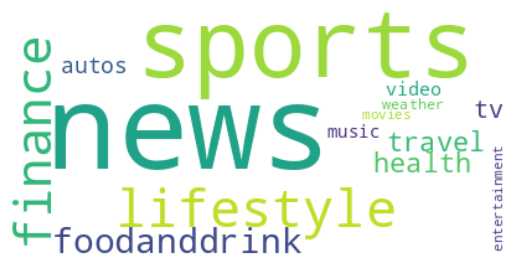

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Generate for all clusters

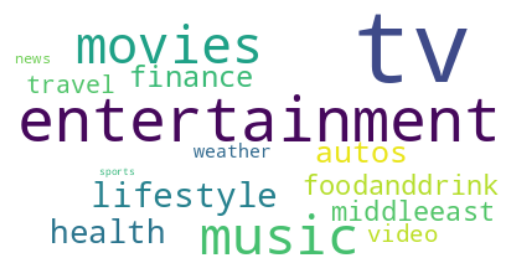

In [43]:
freq_all = pd.DataFrame(index=freq.index)
for cluster in range(int(config['Clustering']['NoClusters'])):
   # get ids of cluster
    cluster_in = (labels == cluster).nonzero()[0]
    cluster_user_ids = [key for key in user_mapping if user_mapping[key] in cluster_in]
    cluster_freq = user_category_frequ.loc[user_category_frequ['user'].isin(cluster_user_ids)]

    # get total sum (not normalized)
    freq = cluster_freq.iloc[:, 2:].sum()
    freq_all[f"{cluster}"] = freq.values
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq)
    # wordcloud = WordCloud(background_color="white").generate_from_frequencies(freq.drop('news', axis=0))

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    wordcloud.to_file(f"../../data/wordclouds/{cluster}_wordcloud.png")


In [27]:
freq_all

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
video,1.208594e-04,3.908478e-05,1.140896e-03,3.419221e-05,5.201817e-05,1.013727e-04,6.225230e-05,3.184600e-05,4.290318e-05,4.627677e-05,4.360825e-05,1.663944e-04,4.388173e-04,3.815818e-06,4.585676e-05,5.916128e-05,1.397419e-03,3.104746e-05,3.481478e-05,1.597938e-05
northamerica,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
sports,1.570995e+01,3.748589e+00,7.602900e+00,4.373400e+00,3.108793e+00,8.219305e+00,7.051776e+00,3.368916e+00,4.673530e+00,3.050307e+00,2.802602e+00,2.089822e+01,3.362528e+01,8.901718e-01,2.659823e+00,3.996346e+00,1.783475e+00,3.075190e+00,4.641597e+00,1.778353e+00
news,4.100180e+01,1.282914e+01,2.829611e+01,1.368465e+01,1.505475e+01,2.855402e+01,2.491562e+01,1.478108e+01,1.613005e+01,1.234519e+01,1.416054e+01,6.702842e+01,9.897481e+01,2.106320e+00,1.308886e+01,1.839383e+01,1.004142e+01,9.257545e+00,1.584765e+01,8.517054e+00
autos,6.367359e-05,2.515476e-05,7.148474e-04,2.075244e-05,2.251664e-05,5.249248e-05,4.041877e-05,2.304627e-05,1.593439e-05,2.050360e-05,3.723711e-05,1.160905e-04,1.590391e-04,4.500406e-06,2.070816e-05,2.389820e-05,4.401758e-04,1.666250e-05,4.397525e-05,8.334159e-06
kids,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.195466e-17,2.242072e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.071779e-17,2.215857e-18,0.000000e+00,0.000000e+00,5.508069e-18,0.000000e+00,0.000000e+00,5.596849e-18,0.000000e+00
movies,5.514269e-07,1.351420e-07,4.081876e-07,1.140265e-07,2.395761e-07,3.101687e-07,1.583567e-07,1.174622e-07,1.255843e-07,2.042681e-07,1.495635e-07,7.109067e-07,9.901470e-07,1.875570e-08,1.757376e-07,2.908699e-07,1.412139e-07,8.505203e-08,1.764368e-07,5.075661e-08
lifestyle,2.482190e-03,6.061804e-04,1.213432e-02,5.885677e-04,1.236638e-03,1.748354e-03,6.857381e-04,4.201227e-04,5.060868e-04,1.321900e-03,6.845412e-04,2.778864e-03,5.049241e-03,7.378647e-05,6.384510e-04,1.228862e-03,1.092872e-02,4.601866e-04,8.593195e-04,3.029892e-04
middleeast,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.991721e-22
foodanddrink,1.338135e-03,2.432436e-04,1.595955e-02,4.259735e-04,6.302590e-04,8.319932e-04,6.729375e-04,3.054506e-04,2.871423e-04,5.487011e-04,3.552129e-04,2.260598e-03,3.449999e-03,3.378910e-05,2.781708e-04,4.348796e-04,4.638136e-04,2.744062e-04,6.796246e-04,2.243749e-04


In [28]:
freq_all_norm = freq_all.div(freq_all.sum(axis=0), axis=1)
freq_all_norm * 100


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
video,2.130766e-04,2.357343e-04,0.003173,1.893160e-04,0.000286,2.756217e-04,1.947126e-04,1.754398e-04,2.062074e-04,0.000300,2.570299e-04,1.892166e-04,3.308823e-04,1.273290e-04,2.911326e-04,2.641813e-04,0.011760,2.517110e-04,1.698847e-04,1.551886e-04
northamerica,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
sports,2.769682e+01,2.260908e+01,21.143684,2.421471e+01,17.112256,2.234743e+01,2.205652e+01,1.855938e+01,2.246258e+01,19.807207,1.651872e+01,2.376456e+01,2.535453e+01,2.970390e+01,1.688652e+01,1.784546e+01,15.008228,2.493148e+01,2.264947e+01,1.727101e+01
news,7.228663e+01,7.737710e+01,78.691544,7.576940e+01,82.868398,7.763539e+01,7.793101e+01,8.142910e+01,7.752654e+01,80.163636,8.346315e+01,7.622187e+01,7.463017e+01,7.028523e+01,8.309773e+01,8.213662e+01,84.500103,7.505368e+01,7.733136e+01,8.271592e+01
autos,1.122572e-04,1.517173e-04,0.001988,1.149025e-04,0.000124,1.427216e-04,1.264217e-04,1.269621e-04,7.658615e-05,0.000133,2.194780e-04,1.320132e-04,1.199205e-04,1.501728e-04,1.314707e-04,1.067161e-04,0.003704,1.350879e-04,2.145848e-04,8.093968e-05
kids,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,3.250347e-17,7.012744e-17,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.218782e-17,1.670827e-18,0.000000e+00,0.000000e+00,2.459597e-17,0.000000,0.000000e+00,2.731079e-17,0.000000e+00
movies,9.721719e-07,8.150894e-07,0.000001,6.313437e-07,0.000001,8.433163e-07,4.953075e-07,6.471002e-07,6.036011e-07,0.000001,8.815371e-07,8.084128e-07,7.466025e-07,6.258537e-07,1.115712e-06,1.298863e-06,0.000001,6.895422e-07,8.609536e-07,4.929381e-07
lifestyle,4.376128e-03,3.656090e-03,0.033746,3.258792e-03,0.006807,4.753591e-03,2.144849e-03,2.314459e-03,2.432426e-03,0.008584,4.034731e-03,3.160006e-03,3.807289e-03,2.462161e-03,4.053359e-03,5.487414e-03,0.091967,3.730870e-03,4.193197e-03,2.942571e-03
middleeast,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.934320e-21
foodanddrink,2.359147e-03,1.467089e-03,0.044384,2.358537e-03,0.003469,2.262103e-03,2.104812e-03,1.682730e-03,1.380104e-03,0.003563,2.093649e-03,2.570656e-03,2.601410e-03,1.127499e-03,1.766034e-03,1.941930e-03,0.003903,2.224693e-03,3.316345e-03,2.179084e-03
